## Script to compare sample clustering and correlation based on metallomics and proteomics 

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr, spearmanr

In [2]:

# Define the directory where the CSV files are located
input_dir_prot = '/Users/aulakhs/Documents/RalserLab/metallica/experiment_data/metpert_WTproteomics/output/tables/completematrix/allmetals/allsamples'

# Define the filenames for the dataframes
filenames = [
    'proteome_pearson_corr.csv',
    'proteome_spearman_corr.csv',
    'proteome_euclidean_dist.csv',
    'proteome_manhattan_dist.csv'
]

# Create an empty list to store the dataframes
proteome_dataframes = []

# Read each dataframe and append it to the list
for filename in filenames:
    df = pd.read_csv(os.path.join(input_dir_prot, filename), index_col=0)
    proteome_dataframes.append(df)


In [3]:

# Define the directory where the CSV files are located
input_dir_metal = '/Users/aulakhs/Documents/RalserLab/metallica/experiment_data/metpert_WTmetallomics/output/tables'

# Define the filenames for the dataframes
filenames = [
    'metallome_pearson_corr.csv',
    'metallome_spearman_corr.csv',
    'metallome_euclidean_dist.csv',
    'metallome_manhattan_dist.csv'
]

# Create an empty list to store the dataframes
metallome_dataframes = []

# Read each dataframe and append it to the list
for filename in filenames:
    df = pd.read_csv(os.path.join(input_dir_metal, filename), index_col=0)
    metallome_dataframes.append(df)
    
    

In [4]:
def calculate_correlation_and_plot(prdf, mtdf):
    # Create an empty list to store individual DataFrames
    dfs_proteome = []

    # Loop through the columns of the original dataframe
    for column_name in prdf.columns:
        # Extract the rowname
        rowname = column_name

        # Create a DataFrame for the current column
        current_df = pd.DataFrame({
            'rowname': [rowname] * len(prdf),
            'column name': prdf.index,
            'proteome coefficient': prdf[column_name].values,
        })

        # Create a sorted unique combination of rowname and column name
        current_df['unique comb'] = current_df.apply(lambda x: '-'.join(sorted([x['rowname'], x['column name']])), axis=1)

        # Append the current DataFrame to the list
        dfs_proteome.append(current_df)

    # Concatenate all the DataFrames into one
    reshaped_proteome_df = pd.concat(dfs_proteome, ignore_index=True)
    reshaped_proteome_df = reshaped_proteome_df.drop_duplicates(subset='unique comb')

    # Create an empty list to store individual DataFrames
    dfs_metallome = []

    # Loop through the columns of the original dataframe
    for column_name in mtdf.columns:
        # Extract the rowname
        rowname = column_name

        # Create a DataFrame for the current column
        current_df = pd.DataFrame({
            'rowname': [rowname] * len(mtdf),
            'column name': mtdf.index,
            'metallome coefficient': mtdf[column_name].values,
        })

        # Create a sorted unique combination of rowname and column name
        current_df['unique comb'] = current_df.apply(lambda x: '-'.join(sorted([x['rowname'], x['column name']])), axis=1)

        # Append the current DataFrame to the list
        dfs_metallome.append(current_df)

    # Concatenate all the DataFrames into one
    reshaped_metallome_df = pd.concat(dfs_metallome, ignore_index=True)
    reshaped_metallome_df = reshaped_metallome_df.drop_duplicates(subset='unique comb')

    # Merge the two dataframes using the unique_comb column
    proteome_metallome_df = reshaped_proteome_df.merge(reshaped_metallome_df, on='unique comb')

    # Remove rows with NaNs
    proteome_metallome_df_cleaned = proteome_metallome_df.dropna(subset=['proteome coefficient', 'metallome coefficient'])

    # Calculate Pearson correlation and p-value
    pearson_corr, pearson_p_value = pearsonr(proteome_metallome_df_cleaned['proteome coefficient'], proteome_metallome_df_cleaned['metallome coefficient'])

    # Calculate Spearman correlation and p-value
    spearman_corr, spearman_p_value = spearmanr(proteome_metallome_df_cleaned['proteome coefficient'], proteome_metallome_df_cleaned['metallome coefficient'])
    
    # Flatten the proteome and metallome coefficients
    proteome_coefficient_flat = proteome_metallome_df_cleaned['proteome coefficient'].values.flatten()
    metallome_coefficient_flat = proteome_metallome_df_cleaned['metallome coefficient'].values.flatten()

    # Calculate the RV coefficient
    rv_coefficient = np.log(np.sum(proteome_coefficient_flat * metallome_coefficient_flat))

    print(f'Pearson Correlation: {pearson_corr:.2f}, P-Value: {pearson_p_value:.4f}')
    print(f'Spearman Correlation: {spearman_corr:.2f}, P-Value: {spearman_p_value:.4f}')
    print(f'RV Coefficient: {rv_coefficient:.2f}')
    
    proteome_metallome_df_cleaned['difference'] = proteome_metallome_df_cleaned['proteome coefficient'] - proteome_metallome_df_cleaned['metallome coefficient']

   # Create a colormap using 'coolwarm' or another colormap of your choice
    cmap = plt.get_cmap('coolwarm')

    # Scatter plot with points colored by the difference column using the colormap
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(data=proteome_metallome_df_cleaned, x='proteome coefficient', y='metallome coefficient', hue='difference', palette=cmap)
    plt.title(f'Pearson Correlation: {pearson_corr:.2f}, Spearman Correlation: {spearman_corr:.2f}')
    plt.xlabel('Proteome Coefficient')
    plt.ylabel('Metallome Coefficient')

    plt.show()

Pearson Correlation: 0.22, P-Value: 0.0000
Spearman Correlation: 0.16, P-Value: 0.0000
RV Coefficient: 5.01


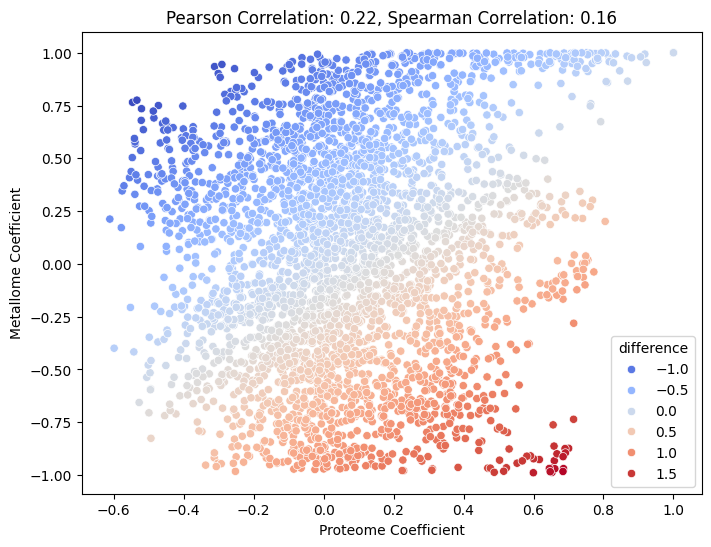

Pearson Correlation: 0.24, P-Value: 0.0000
Spearman Correlation: 0.18, P-Value: 0.0000
RV Coefficient: 5.14


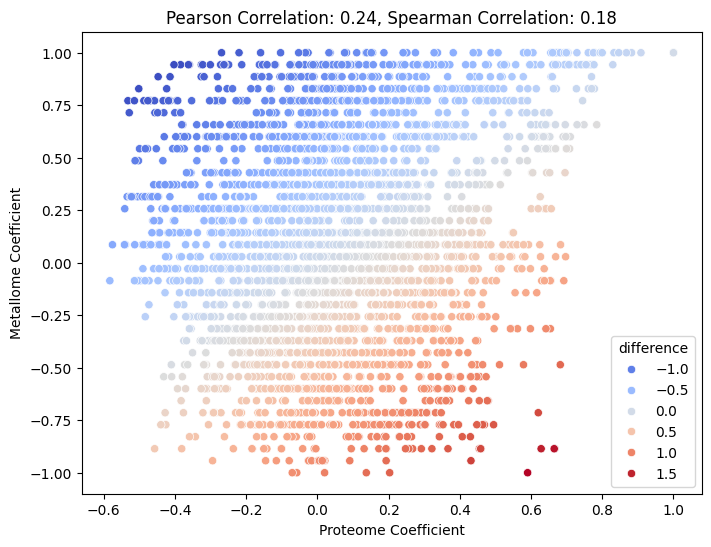

Pearson Correlation: -0.21, P-Value: 0.0000
Spearman Correlation: -0.18, P-Value: 0.0000
RV Coefficient: 4.98


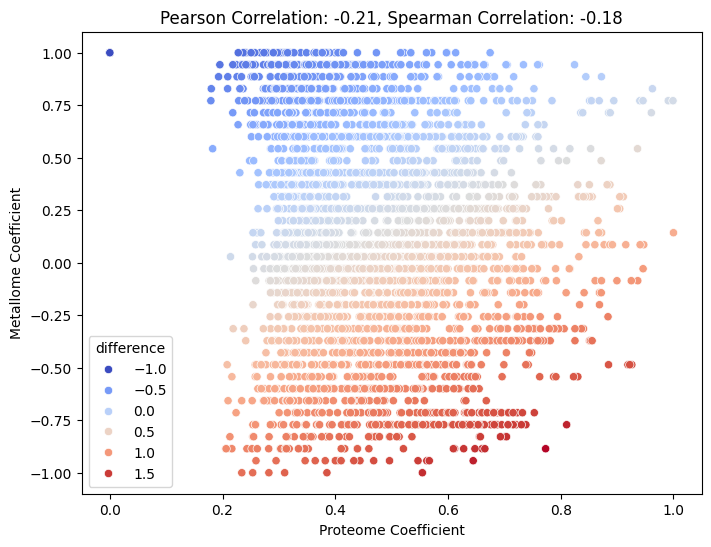

Pearson Correlation: 0.24, P-Value: 0.0000
Spearman Correlation: 0.37, P-Value: 0.0000
RV Coefficient: 8.01


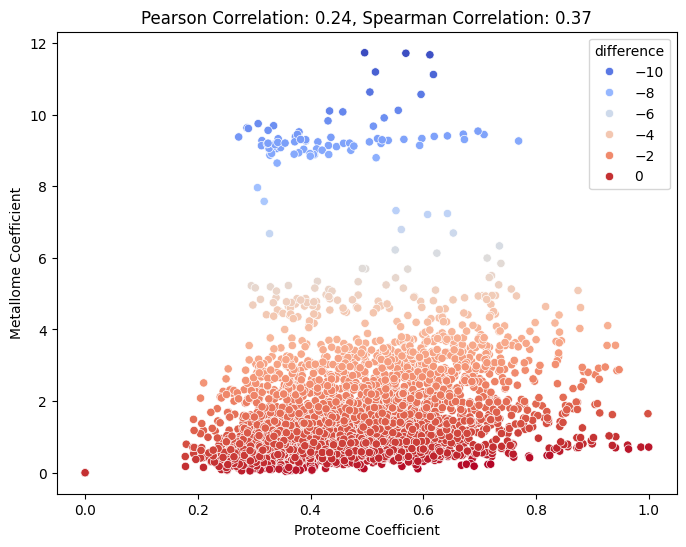

In [5]:

# Loop through corresponding datasets
for prdf, mtdf in zip(proteome_dataframes, metallome_dataframes):
    calculate_correlation_and_plot(prdf, mtdf)

In [6]:
sp_corr_prot = proteome_dataframes[1]

# Extract the upper triangle (excluding the diagonal) of the DataFrame
upper_triangle = np.triu(sp_corr_prot.values, k=1)

# Create a DataFrame from the upper triangle
upper_triangle_df = pd.DataFrame(upper_triangle, columns=sp_corr_prot.columns, index=sp_corr_prot.index)

# Stack the DataFrame to convert it to long format
stacked_df = upper_triangle_df.stack()

# Reset the index to have BioSpecID as rownames and colnames as columns
result_df = stacked_df.reset_index()

# Rename the columns
result_df.columns = ['BioSpecID', 'colname', 'coefficient']

# Separate BioSpecIDs into metal and conc
result_df[['metal1', 'conc1']] = result_df['BioSpecID'].str.split(' ', expand=True)
result_df[['metal2', 'conc2']] = result_df['colname'].str.split(' ', expand=True)

# Filter rows where metal1 is not equal to metal2
result_df = result_df[result_df['metal1'] != result_df['metal2']]

result_df.reset_index(drop=True, inplace=True)


In [7]:

result_df = result_df[result_df['coefficient'] != 0]


In [8]:
metp_metm_df = pd.read_csv('/Users/aulakhs/Documents/RalserLab/metallica/experiment_data/metpert_WTmetallomics/output/tables/metalperturbed_metalmeasured_correlations.csv')

metp_metm_df_protcorr_df = pd.merge(result_df[['metal1',
                                              'metal2',
                                              'coefficient']], metp_metm_df[['element_perturbed',
                                                             'element_measured',
                                                             'spearman']], left_on=['metal1', 'metal2'],
                                    right_on=['element_perturbed', 'element_measured'], 
                                    how='inner')
metp_metm_df_protcorr_df = metp_metm_df_protcorr_df.rename(columns={
    'coefficient': 'proteome coefficient',
    'spearman': 'metalperturbed_metalmeasured_sp_coeff'
})
metp_metm_df_protcorr_df = metp_metm_df_protcorr_df.drop(columns=['metal1', 'metal2'])

metp_metm_df_protcorr_df = metp_metm_df_protcorr_df.drop_duplicates()

In [9]:
metp_metm_df_protcorr_df

,proteome coefficient,element_perturbed,element_measured,metalperturbed_metalmeasured_sp_coeff
0,0.310395,Ca,Fe,0.184634
1,0.467097,Ca,Fe,0.184634
2,0.400796,Ca,Fe,0.184634
3,0.082762,Ca,Fe,0.184634
4,0.153201,Ca,Fe,0.184634
...,...,...,...,...
2756,0.291523,Na,Zn,0.151517
2757,0.395557,Na,Zn,0.151517
2758,0.295521,Na,Zn,0.151517
2759,0.253807,Na,Zn,0.151517


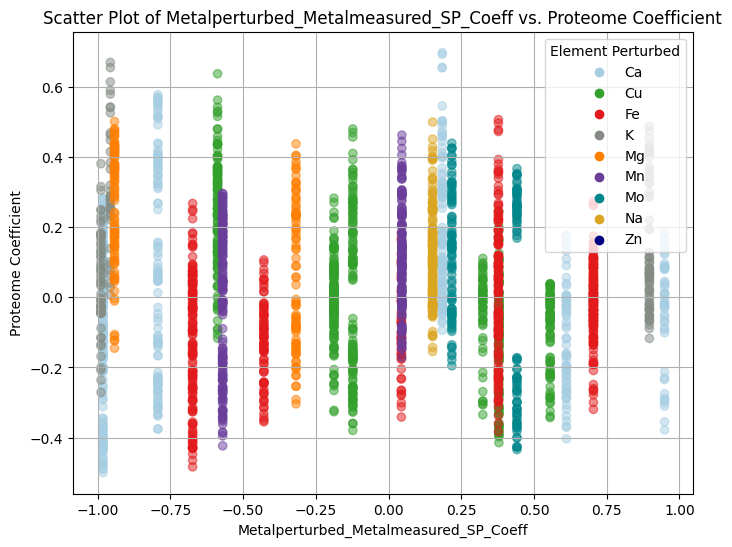

In [10]:
# Define a dictionary that maps elements to colors
element_color_mapping = {
    'Ca': "#A6CEE3",
    'Cu': "#33A02C",
    'Fe': "#E31A1C",
    'K': "#838B83",
    'Mg': "#FF7F00",
    'Mn': "#6A3D9A",
    'Mo': "#00868B",
    'Na': "#DAA520",
    'Zn': "#000080"
}

# Apply the color mapping to the 'element_perturbed' column
metp_metm_df_protcorr_df['color'] = metp_metm_df_protcorr_df['element_perturbed'].map(element_color_mapping)

# Create the scatter plot with custom colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    metp_metm_df_protcorr_df['metalperturbed_metalmeasured_sp_coeff'],
    metp_metm_df_protcorr_df['proteome coefficient'],
    c=metp_metm_df_protcorr_df['color'],  # Use the 'color' column for colors
    alpha=0.5
)

plt.xlabel('Metalperturbed_Metalmeasured_SP_Coeff')
plt.ylabel('Proteome Coefficient')
plt.title('Scatter Plot of Metalperturbed_Metalmeasured_SP_Coeff vs. Proteome Coefficient')
plt.grid(True)

# Add a legend for element colors
for element, color in element_color_mapping.items():
    plt.scatter([], [], c=color, label=element)

# Show the legend
plt.legend(loc='upper right', title='Element Perturbed')

plt.show()


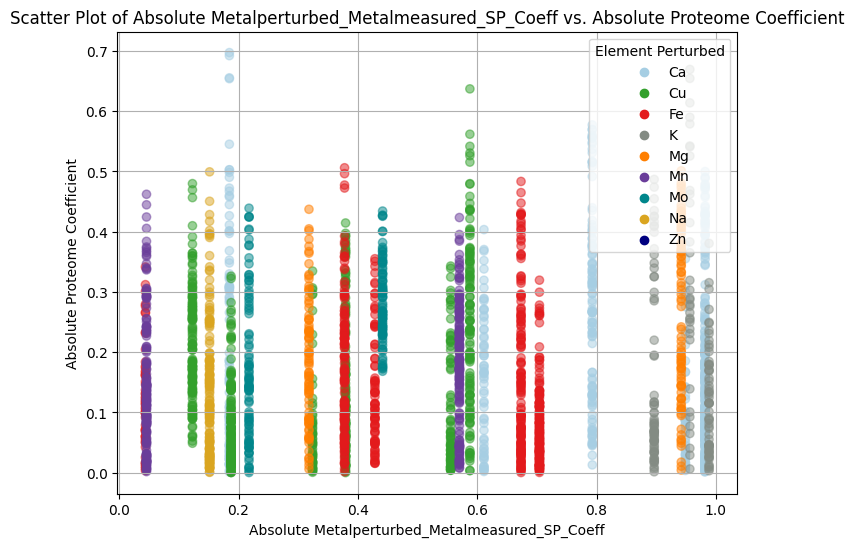

In [11]:

# Take the absolute values of the 'metalperturbed_metalmeasured_sp_coeff' and 'proteome coefficient' columns
metp_metm_df_protcorr_df['abs_metalperturbed_metalmeasured_sp_coeff'] = np.abs(metp_metm_df_protcorr_df['metalperturbed_metalmeasured_sp_coeff'])
metp_metm_df_protcorr_df['abs_proteome_coefficient'] = np.abs(metp_metm_df_protcorr_df['proteome coefficient'])

# Create the scatter plot with absolute values
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    metp_metm_df_protcorr_df['abs_metalperturbed_metalmeasured_sp_coeff'],
    metp_metm_df_protcorr_df['abs_proteome_coefficient'],
    c=metp_metm_df_protcorr_df['color'],  # Use the 'color' column for colors
    alpha=0.5
)

plt.xlabel('Absolute Metalperturbed_Metalmeasured_SP_Coeff')
plt.ylabel('Absolute Proteome Coefficient')
plt.title('Scatter Plot of Absolute Metalperturbed_Metalmeasured_SP_Coeff vs. Absolute Proteome Coefficient')
plt.grid(True)

# Add a legend for element colors
for element, color in element_color_mapping.items():
    plt.scatter([], [], c=color, label=element)

# Show the legend
plt.legend(loc='upper right', title='Element Perturbed')

plt.show()
